In [1]:
# import Libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from tqdm.notebook import tqdm
import torch.nn.functional as F


from PIL import Image

from torch import nn
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset


In [2]:
# Paths to directories

train = "/kaggle/input/whu-building-dataset/WHU building/train"
test = "/kaggle/input/whu-building-dataset/WHU building/test"
valid = "/kaggle/input/whu-building-dataset/WHU building/val"

In [3]:
class WHUBuildingDataset(Dataset):
    def __init__(self, categories=['train', 'test', 'val'], transform=None, target_transform=None):
        self.BASEDIR = '../input/whu-building-dataset/WHU building'
        self.image_idx = []
        for category in categories:
            folder = f"{self.BASEDIR}/{category}"
            image_idx = os.listdir(f"{folder}/A")
            self.image_idx.extend(image_idx)
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        image_name = self.image_idx[idx]
        category = ''
        for c in ['train', 'test', 'val']:
            if image_name in os.listdir(f"{self.BASEDIR}/{c}/A"):
                category = c
                break
        assert category != '', f"Image {image_name} not found in any of the categories"
        
        img = read_image(f"{self.BASEDIR}/{category}/A/{image_name}", mode=ImageReadMode.RGB) / 255 
        seg = read_image(f"{self.BASEDIR}/{category}/OUT/{image_name}", mode=ImageReadMode.GRAY) / 255

        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)

        if self.target_transform:
            seg = self.target_transform(mask)
            
        return img, seg

In [4]:
def load_dataset(category='train'):
    cat = ['train', 'val'] if category=='train' else ['test']
    # Augment
    transform_augment = transforms.Compose([
    transforms.Resize((256, 256)),    
#     transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
    ])
    # Load Base and Augmented
    dataset_base = WHUBuildingDataset(categories=cat, transform=transforms.Resize((256, 256)))
    dataset_aug = WHUBuildingDataset(categories=cat, transform=transform_augment)
    # Concat and return
    dataset = ConcatDataset([dataset_base, dataset_aug])
    return dataset
    

In [5]:
# Variables
BATCH_SIZE = 5
NUM_WORKERS = 0

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

if DEVICE == 'cuda':
    device_name = torch.cuda.get_device_name(0)
    print(f"Setting compute device to {DEVICE} on {device_name}")


Setting compute device to cuda on Tesla T4


In [6]:
# Create and load dataset

dataset = load_dataset('train')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(10,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.axis(False)
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image.permute(1,2,0))
    plt.show()

Length of train dataset: 11545
Shape of Image: torch.Size([3, 256, 256])
Shape of Segmentation mask: torch.Size([1, 256, 256])


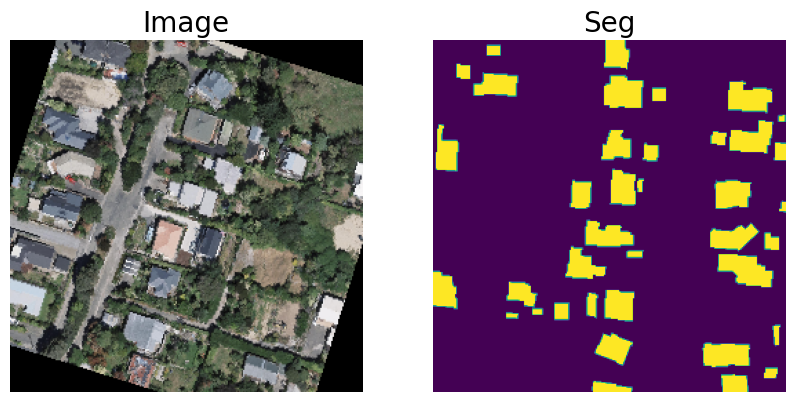

In [8]:
image, seg = next(iter(dataloader))
print(f"Length of train dataset: {len(dataloader) * BATCH_SIZE}")
print(f"Shape of Image: {image[0].shape}")
print(f"Shape of Segmentation mask: {seg[0].shape}")
visualize(image=image[0], seg=seg[0])

In [9]:
image.min(), image.max(), seg.min(), seg.max()

(tensor(0.), tensor(0.9980), tensor(0.), tensor(1.))

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNetLite(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNetLite, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 32)
        self.down_conv2 = DownBlock(32, 64)
        self.down_conv3 = DownBlock(64, 128)
#         self.down_conv4 = DownBlock(128, 256)
        # Bottleneck
        self.double_conv = DoubleConv(128, 256)
        # Upsampling Path
#         self.up_conv4 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv3 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv2 = UpBlock(64 + 128, 64, self.up_sample_mode)
        self.up_conv1 = UpBlock(32 + 64, 32, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(32, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
#         x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
#         x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    
    

In [15]:
# Define the ensemble model with 3 U-Nets
class EnsembleUNet(nn.Module):
    def __init__(self, num_classes=1):
        super(EnsembleUNet, self).__init__()
        # Instantiate 3 U-Nets
        self.unet1 = UNetLite()
        self.unet2 = UNetLite()
        self.unet3 = UNetLite()
        # Define the output layer for the ensemble model
        self.output_layer = nn.Conv2d(3*num_classes, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Pass the input through each U-Net
        output1 = self.unet1(x)
        output2 = self.unet2(x)
        output3 = self.unet3(x)
        # Concatenate the outputs from the 3 U-Nets along the channel dimension
        combined_output = torch.cat([output1, output2, output3], dim=1)
        # Pass the concatenated output through the output layer
        output = self.output_layer(combined_output)
        return output

In [16]:
model = EnsembleUNet().to(DEVICE)

In [17]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 6882631


In [18]:
model = UNetLite().to(DEVICE)

In [19]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 2294209


In [20]:
# Loss Function 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [21]:
# Training Variables
EPOCHS = 5
LEARNING_RATE = 1e-3

In [22]:
criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
def train(
    model=model,
    dataloader=dataloader,
    criterion=criterion, 
    optimizer=optimizer,
    device=DEVICE,
    epochs=EPOCHS
):
    model.train() # Set the model in training mode
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0
        n_batch = 0
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device, non_blocking=True) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device, non_blocking=True)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        epoch_loss = running_loss / n_batch
        loss_list.append(epoch_loss)
        
        print(f"Epoch {epoch + 1 }: Training Loss {epoch_loss:.6f}")
    
    return loss_list


In [24]:
losses = train(model)

  0%|          | 0/2309 [00:00<?, ?it/s]

Epoch 1: Training Loss 0.315257


  0%|          | 0/2309 [00:00<?, ?it/s]

Epoch 2: Training Loss 0.296725


  0%|          | 0/2309 [00:00<?, ?it/s]

Epoch 3: Training Loss 0.284721


  0%|          | 0/2309 [00:00<?, ?it/s]

Epoch 4: Training Loss 0.274832


  0%|          | 0/2309 [00:00<?, ?it/s]

Epoch 5: Training Loss 0.267665


Text(0, 0.5, 'Loss')

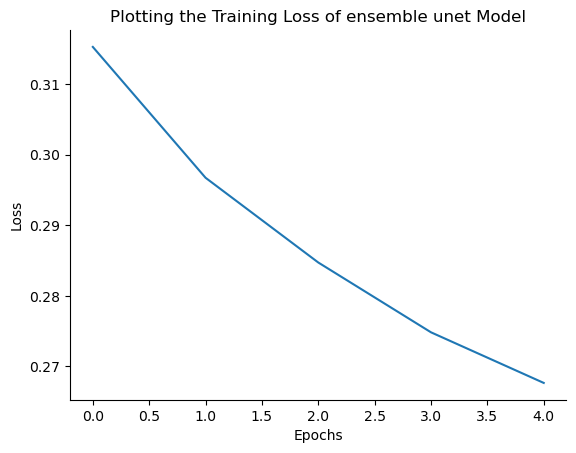

In [25]:
# Plot the loss curve
plt.plot(losses)

sns.despine()
plt.title("Plotting the Training Loss of ensemble unet Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Save the model

In [26]:
torch.save(model, "unet.pth")

Visulaization of one image

In [27]:
image, seg = next(iter(dataloader))
pred = model(image.to(DEVICE))
pred = pred.cpu().detach()

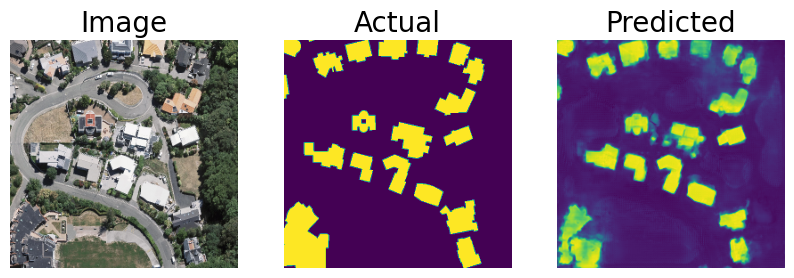

In [28]:
visualize(image=image[0], actual=seg[0], predicted=pred[0])

## Testing

In [35]:
torch.manual_seed(0)
test_dataset = load_dataset(category='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [36]:
len(test_dataloader) * BATCH_SIZE

4835

In [33]:
def test(model=model, dataloader=test_dataloader, device=DEVICE):
    
    model.eval() # Set model to evaluation mode
    running_loss = 0
    n_batch = 0
    with torch.no_grad():
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device, non_blocking=True) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device, non_blocking=True)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1

        epoch_loss = running_loss / n_batch

    print(f"Testing Loss {epoch_loss:.6f}")
    
    return epoch_loss

In [34]:
test_loss = test(model)

  0%|          | 0/967 [00:00<?, ?it/s]

Testing Loss 0.219419


In [39]:
image, seg = next(iter(test_dataloader))
pred = model(image.to(DEVICE))
pred = pred.cpu().detach()

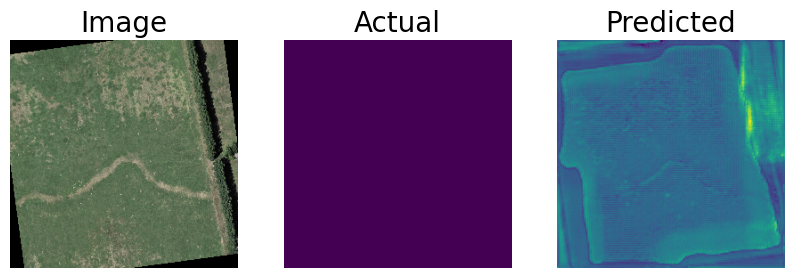

In [38]:
visualize(image=image[0], actual=seg[0], predicted=pred[0])

In [64]:
from IPython.display import FileLink
FileLink('ensemble-unet.pth')

/kaggle/working/ensemble-unet.pth